# 1. Clustering-Based Anomaly Detection: K-Means

## Concept & Theory

- The core idea behind using k-means for anomaly detection is to group data points into clusters. Normal data points will tend to be close to the center of a cluster (centroid), while anomalies will be far from any cluster centroid. The distance of a data point from its nearest cluster centroid can be used as an anomaly score.

1. **Clustering**: The k-means algorithm partitions the data into *k* clusters by minimizing the within-cluster sum of squares (WCSS):

    $$ \text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2 $$

    where $C_i$ is the $i$-th cluster and $\mu_i$ is its centroid.

2. **Anomaly Score**: For any data point $x$, its anomaly score is its Euclidean distance to the nearest centroid:

$$ \text{Anomaly Score}(x) = \min_{i=1,...,k} ||x - \mu_i||^2 $$

3. **Thresholding**: A threshold is set on the anomaly scores to classify points as anomalies. A common approach is to use a quantile of the distances.

## Python Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

### 1. Generate Sample Data

In [8]:
# Generate isotropic Gaussian blobs for clustering\n",
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
print(X.shape)
# Add some outliers,
outliers = np.array([[0, 5],[6, 2]])
X = np.concatenate([X, outliers])


(300, 2)


### 2. Fit K-Means Model


In [9]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X)

### 3. Calculate Anomaly Scores


In [10]:
# Calculate the distance from each point to its closest cluster center,
distances = np.min(kmeans.transform(X), axis=1)

# Set an anomaly threshold (e.g., 95th percentile),
threshold = np.quantile(distances, 0.95)

# Identify anomalies,
anomalies = X[distances > threshold]


### 4. Visualize Results


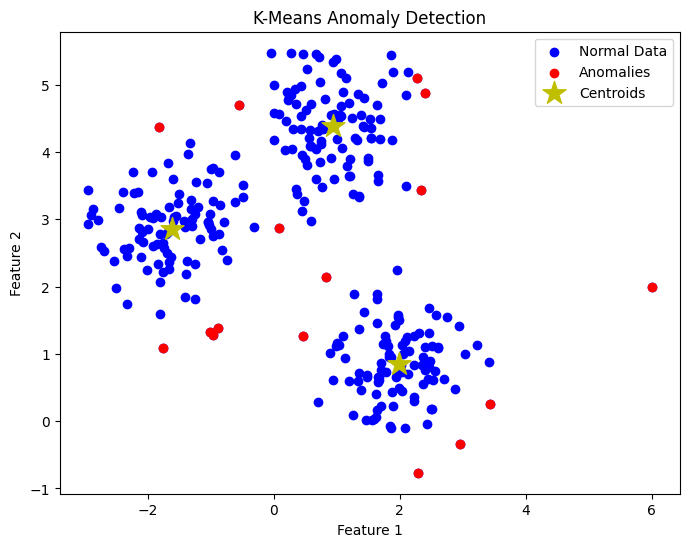

In [11]:
plt.figure(figsize=(8, 6)),
plt.scatter(X[:, 0], X[:, 1], c='b', label='Normal Data'),
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies'),
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='y', marker='*', label='Centroids'),
plt.title('K-Means Anomaly Detection'),
plt.xlabel('Feature 1'),
plt.ylabel('Feature 2'),
plt.legend(),
plt.show()


## Pros & Cons
### Pros
- **Simple and easy to implement.**: K-means is a well-understood algorithm.
- **Efficient**: It is computationally efficient for large datasets.
- **Scalable**: The algorithm scales well to a large number of samples.

### Cons
- **Requires specifying *k***: The number of clusters must be set beforehand.
- **Assumes spherical clusters**: K-means performs poorly on clusters with complex shapes.
- **Sensitive to initialization**: The initial placement of centroids can affect the final clustering

## When to Use
K-means is a good choice for anomaly detection when:
- The clusters are expected to be roughly spherical.
- The number of clusters (*k*) is known or can be estimated.
- The dataset is large and computational efficiency is important.
